<a href="https://colab.research.google.com/github/AnIsAsPe/Regresion-con-penalizacion/blob/main/Games_of_thrones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar bibiliotecas

In [1]:
import pandas as pd
import numpy as np

import os
from wordcloud import WordCloud
from PIL import Image 

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt 
import seaborn as sns  

nltk.download('stopwords')
nltk.download('wordnet')  #WordNetLemmatizer
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Funciones

#### correlacion()

In [2]:
def correlacion(dataframe, grafica=True, matrix=False, tamaño =(5,4)):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()                   
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm", 
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(), 
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

#### elimina_stopwords()

In [3]:
def elimina_stopwords(texto):
  nuevo_texto = ' '.join([palabra for palabra in str(texto).split() if
                          palabra not in stopwords.words('english')])
  return nuevo_texto

### elimina_puntuacion()

In [4]:
def elimina_puntuacion(texto):
  puntuacion = set(string.punctuation)
  nuevo_texto = ''.join (c for c in texto if c not in puntuacion)
  return nuevo_texto


#### lematizar()

In [5]:
lemmatizer = WordNetLemmatizer()

def lematizar(texto):
  texto=texto.split()
  nuevo_texto = " ".join([lemmatizer.lemmatize(i) for i in texto])
  return nuevo_texto

#### stemmer()

In [6]:
st = PorterStemmer()

def stemmer(texto):
  texto=texto.split()
  nuevo_texto =" ".join([st.stem(i) for i in texto])
  return nuevo_texto

#### tokenizar()

In [7]:
def tokenizar(texto):
  nuevo_texto =word_tokenize(texto)
  return nuevo_texto

#### preprocesar(texto)


In [8]:
def preprocesar(texto):
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion(texto)
  texto = stemmer(texto)
  return(texto)


## Leer Datos


In [10]:
#from google.colab import  files
#files.upload()

In [11]:
datos = pd.read_csv('got_data.csv')
datos.head(3)

,Season,Episode Number,Number in Season,Episode Name,Director,Writer,Original Air Date,US viewers (million),Runtime (mins),IMDB Description,IMDB votes,Imdb Rating,Notable Death Count
0,1,1,1,Winter Is Coming,Tim Van Patten,David Benioff & D. B. Weiss,"April 17, 2011",2.22,62,"Jon Arryn, the Hand of the King, is dead. King...",27685,9.0,4
1,1,2,2,The Kingsroad,Tim Van Patten,David Benioff & D. B. Weiss,"April 24, 2011",2.20,56,"While Bran recovers from his fall, Ned takes o...",21256,8.8,3
2,1,3,3,Lord Snow,Brian Kirk,David Benioff & D. B. Weiss,"May 1, 2011",2.44,58,Lord Stark and his daughters arrive at King's ...,20090,8.7,0


In [12]:
id = datos.columns[0:4].to_list()
id.append(datos.columns[6])

In [13]:
df = datos.drop(columns=id)

In [14]:
#Llevar columna de clase (Imdb Rating) hasta la última posición

cols = df.columns.tolist()
df = df[[c for c in df if c != 'Imdb Rating'] + ['Imdb Rating']]

print(df.shape)
df.head(3)

(73, 8)


,Director,Writer,US viewers (million),Runtime (mins),IMDB Description,IMDB votes,Notable Death Count,Imdb Rating
0,Tim Van Patten,David Benioff & D. B. Weiss,2.22,62,"Jon Arryn, the Hand of the King, is dead. King...",27685,4,9.0
1,Tim Van Patten,David Benioff & D. B. Weiss,2.20,56,"While Bran recovers from his fall, Ned takes o...",21256,3,8.8
2,Brian Kirk,David Benioff & D. B. Weiss,2.44,58,Lord Stark and his daughters arrive at King's ...,20090,0,8.7


## Analisis Exploratorio

### Exploración de las variables las numéricas

In [15]:
numericas = df.select_dtypes(exclude='object')
numericas.head()

,US viewers (million),Runtime (mins),IMDB votes,Notable Death Count,Imdb Rating
0,2.22,62,27685,4,9.0
1,2.20,56,21256,3,8.8
2,2.44,58,20090,0,8.7
3,2.45,56,19123,1,8.8
4,2.58,55,20062,5,9.1


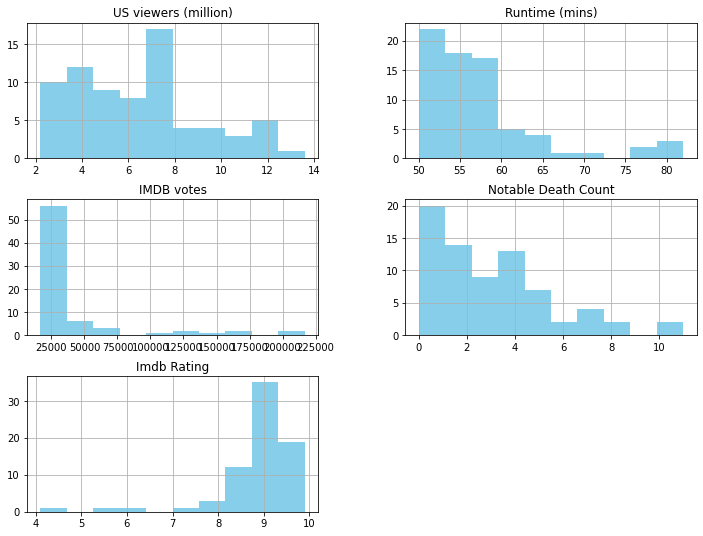

In [16]:
df.hist(figsize=(12,9), color='skyblue')
plt.show()

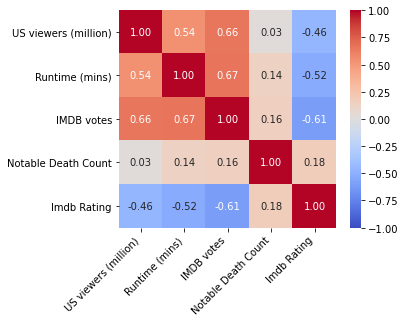

In [17]:
correlacion(df)

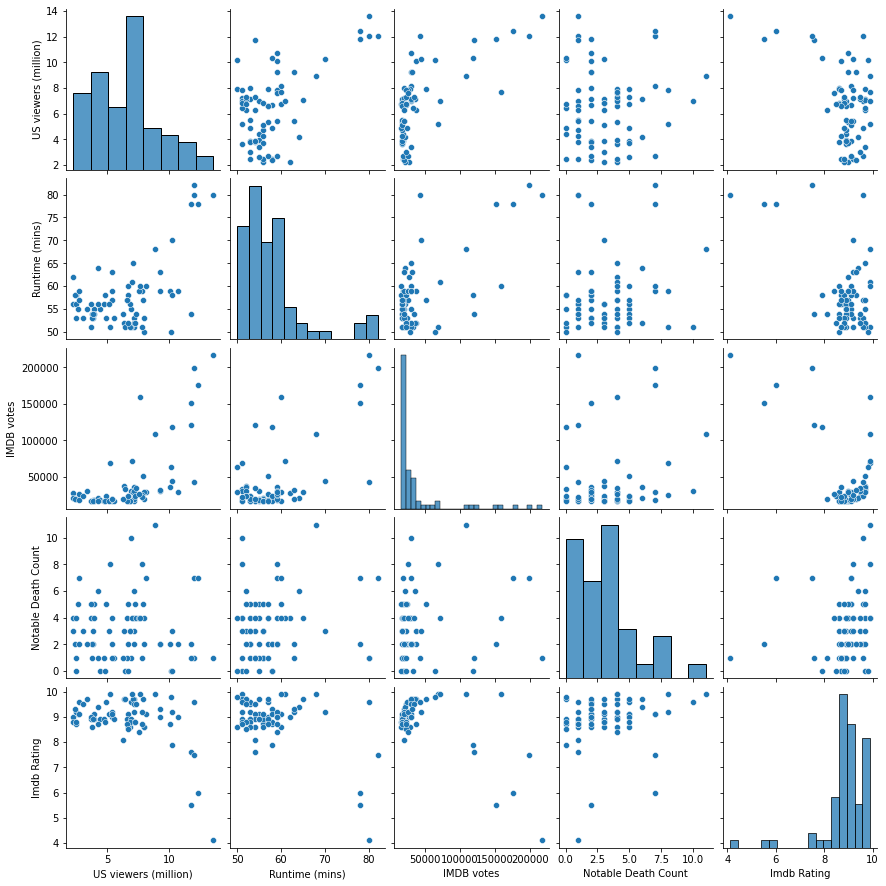

In [18]:
g = sns.pairplot(df)
plt.show()

### Exploración de las variables categóricas

In [19]:
categoricas = df.select_dtypes(include='object')
categoricas.drop('IMDB Description', axis=1, inplace=True)
categoricas.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Director,Writer
0,Tim Van Patten,David Benioff & D. B. Weiss
1,Tim Van Patten,David Benioff & D. B. Weiss
2,Brian Kirk,David Benioff & D. B. Weiss
3,Brian Kirk,Bryan Cogman
4,Brian Kirk,David Benioff & D. B. Weiss


In [20]:
for col in categoricas.columns:
  print('{} \n{}\n'.format(col.upper(), categoricas[col].value_counts()))

DIRECTOR 
David Nutter                   9
Alan Taylor                    7
Miguel Sapochnik               6
Mark Mylod                     6
Alex Graves                    6
Jeremy Podeswa                 6
Daniel Minahan                 5
Michelle MacLaren              4
Alik Sakharov                  4
Brian Kirk                     3
Daniel Sackheim                2
Matt Shakman                   2
Michael Slovis                 2
Tim Van Patten                 2
David Petrarca                 2
Neil Marshall                  2
Jack Bender                    2
David Benioff                  1
D. B. Weiss                    1
David Benioff & D. B. Weiss    1
Name: Director, dtype: int64

WRITER 
David Benioff & D. B. Weiss                                  42
Bryan Cogman                                                 11
David Benioff & D. B. Weiss                                   7
Dave Hill                                                     4
George R. R. Martin                 

#### Transformación de variables

In [21]:
df['Writer_1']= np.where(df.Writer.str.contains('David Benioff'), 
                        'David Benioff & D. B. Weiss ', df['Writer'])


In [22]:
df[df['Writer'].str.contains(r'Story by')]

,Director,Writer,US viewers (million),Runtime (mins),IMDB Description,IMDB votes,Notable Death Count,Imdb Rating,Writer_1
5,Daniel Minahan,Story by : Jane Espenson and David Benioff & D...,2.44,53,"While recovering from his battle with Jaime, E...",19908,4,9.2,David Benioff & D. B. Weiss


In [23]:
df.loc[5,'Writer_1'] = 'Jane Espenson & David Benioff and D. B. Weiss'
df.Writer_1.value_counts()

David Benioff & D. B. Weiss                      50
Bryan Cogman                                     11
Dave Hill                                         4
George R. R. Martin                               4
Vanessa Taylor                                    3
Jane Espenson & David Benioff and D. B. Weiss     1
Name: Writer_1, dtype: int64

In [24]:
df=df.drop('Writer',axis=1)

In [25]:
categoricas = df.select_dtypes(include='object')
categoricas = categoricas.drop('IMDB Description', axis=1)
for col in categoricas.columns:
  print('{} \n{}\n'.format(col.upper(), categoricas[col].value_counts()))

DIRECTOR 
David Nutter                   9
Alan Taylor                    7
Miguel Sapochnik               6
Mark Mylod                     6
Alex Graves                    6
Jeremy Podeswa                 6
Daniel Minahan                 5
Michelle MacLaren              4
Alik Sakharov                  4
Brian Kirk                     3
Daniel Sackheim                2
Matt Shakman                   2
Michael Slovis                 2
Tim Van Patten                 2
David Petrarca                 2
Neil Marshall                  2
Jack Bender                    2
David Benioff                  1
D. B. Weiss                    1
David Benioff & D. B. Weiss    1
Name: Director, dtype: int64

WRITER_1 
David Benioff & D. B. Weiss                      50
Bryan Cogman                                     11
Dave Hill                                         4
George R. R. Martin                               4
Vanessa Taylor                                    3
Jane Espenson & David Benioff 

### Relación escritor y director con calificación 

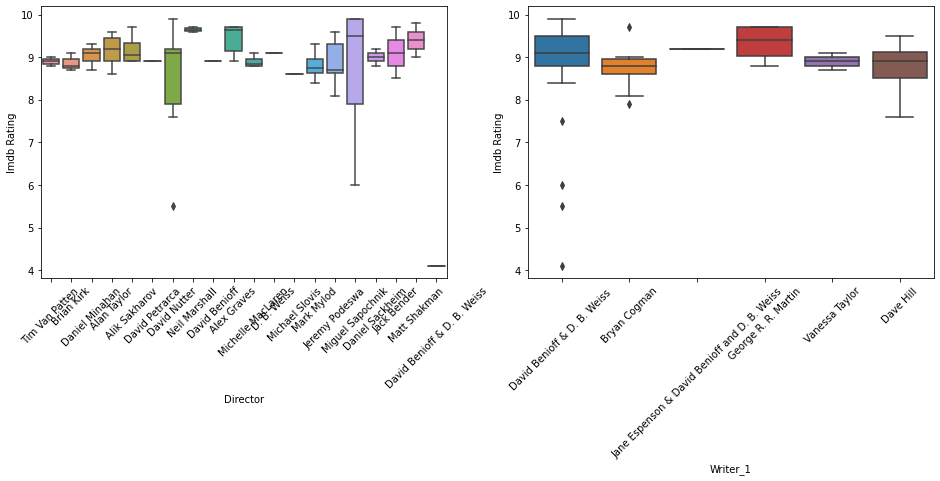

In [26]:

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
for var, subplot in zip(categoricas, ax.flatten()):
    sns.boxplot(x=var, y='Imdb Rating', data=df, ax=subplot, showfliers=True)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

#### Hot Encoding Escritor y Director

In [27]:
categoricas_he = pd.get_dummies(categoricas)
categoricas_he

,Director_Alan Taylor,Director_Alex Graves,Director_Alik Sakharov,Director_Brian Kirk,Director_D. B. Weiss,Director_Daniel Minahan,Director_Daniel Sackheim,Director_David Benioff,Director_David Benioff & D. B. Weiss,Director_David Nutter,Director_David Petrarca,Director_Jack Bender,Director_Jeremy Podeswa,Director_Mark Mylod,Director_Matt Shakman,Director_Michael Slovis,Director_Michelle MacLaren,Director_Miguel Sapochnik,Director_Neil Marshall,Director_Tim Van Patten,Writer_1_Bryan Cogman,Writer_1_Dave Hill,Writer_1_David Benioff & D. B. Weiss,Writer_1_George R. R. Martin,Writer_1_Jane Espenson & David Benioff and D. B. Weiss,Writer_1_Vanessa Taylor
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
70,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


### Exploración de la descripción de los capítulos

In [28]:
df['IMDB Description']

0     Jon Arryn, the Hand of the King, is dead. King...
1     While Bran recovers from his fall, Ned takes o...
2     Lord Stark and his daughters arrive at King's ...
3     Eddard investigates Jon Arryn's murder. Jon be...
4     Catelyn has captured Tyrion and plans to bring...
                            ...                        
68    Jaime faces judgment and Winterfell prepares f...
69    The Night King and his army have arrived at Wi...
70    The Battle of Winterfell is over and a new cha...
71    Forces have arrived at King's Landing for the ...
72    In the aftermath of the devastating attack on ...
Name: IMDB Description, Length: 73, dtype: object

In [29]:
df['IMDB Description'].str.len().describe()

count     73.000000
mean     178.986301
std       45.301917
min       59.000000
25%      163.000000
50%      188.000000
75%      212.000000
max      238.000000
Name: IMDB Description, dtype: float64

In [30]:
# Ver la descripción que tiene elmenor  número de caractéres
shortest_des = df['IMDB Description'].index[df['IMDB Description'].str.len() == 59][0]
df['IMDB Description'][shortest_des]

"Forces have arrived at King's Landing for the final battle."

In [31]:
# Ver la descripción que tiene el mayor número de caractéres
longest_des = df['IMDB Description'].index[df['IMDB Description'].str.len() == 238][0]
df['IMDB Description'][longest_des]

"Tyrion arrives at King's Landing to take his father's place as Hand of the King. Stannis Baratheon plans to take the Iron Throne for his own. Robb tries to decide his next move in the war. The Night's Watch arrive at the house of Craster."

# Preprocesamiento de texto

In [32]:
ejemplo = df['IMDB Description'][longest_des]
ejemplo

"Tyrion arrives at King's Landing to take his father's place as Hand of the King. Stannis Baratheon plans to take the Iron Throne for his own. Robb tries to decide his next move in the war. The Night's Watch arrive at the house of Craster."

#### Transformar texto a minúsculas

In [33]:
ejemplo = ejemplo.lower()
ejemplo

"tyrion arrives at king's landing to take his father's place as hand of the king. stannis baratheon plans to take the iron throne for his own. robb tries to decide his next move in the war. the night's watch arrive at the house of craster."

#### Quitar puntuación

In [34]:
ejemplo = elimina_puntuacion(ejemplo)
ejemplo

'tyrion arrives at kings landing to take his fathers place as hand of the king stannis baratheon plans to take the iron throne for his own robb tries to decide his next move in the war the nights watch arrive at the house of craster'

#### Quitar Palabras Irrelevantes ("Stopwords")

In [35]:
ejemplo = elimina_stopwords(ejemplo)
ejemplo

'tyrion arrives kings landing take fathers place hand king stannis baratheon plans take iron throne robb tries decide next move war nights watch arrive house craster'

## Normalización
Existen dos principales técnicas para normalizar el texto, la lematización y "radicalización" o stemming, que consiste en la  conversión de palabras en las raices

Referencia: 

https://towardsdatascience.com/introduction-to-nlp-part-2-difference-between-lemmatisation-and-stemming-3789be1c55bc

In [36]:
ejemplo_lema = lematizar(ejemplo)
ejemplo_lema

'tyrion arrives king landing take father place hand king stannis baratheon plan take iron throne robb try decide next move war night watch arrive house craster'

In [37]:
ejemplo_stem = stemmer(ejemplo)
ejemplo_stem

'tyrion arriv king land take father place hand king stanni baratheon plan take iron throne robb tri decid next move war night watch arriv hous craster'

## Todo junto

In [38]:
df['IMDB Description_pp'] = df['IMDB Description'].apply(preprocesar)
df['IMDB Description_pp'].head()

0    jon arryn hand king dead king robert baratheon...
1    bran recov fall ned take daughter king land jo...
2    lord stark daughter arriv king land discov int...
3    eddard investig jon arryn murder jon befriend ...
4    catelyn captur tyrion plan bring sister lysa a...
Name: IMDB Description_pp, dtype: object

# Vectorización del texto

In [39]:
Corpus = df['IMDB Description_pp']
Corpus


0     jon arryn hand king dead king robert baratheon...
1     bran recov fall ned take daughter king land jo...
2     lord stark daughter arriv king land discov int...
3     eddard investig jon arryn murder jon befriend ...
4     catelyn captur tyrion plan bring sister lysa a...
                            ...                        
68       jaim face judgment winterfel prepar battl come
69    night king armi arriv winterfel great battl begin
70            battl winterfel new chapter westero begin
71                     forc arriv king land final battl
72    aftermath devast attack king land daeneri must...
Name: IMDB Description_pp, Length: 73, dtype: object

## Bolsa de palabras del corpus con frecuencias de palabras en documentos

In [40]:
 #inicializa 
cv = CountVectorizer()

#obtiene el diccionario de palabras y la matriz documento-termino
mdt_frec = cv.fit_transform(Corpus) 
                                                         
mdt_frec.shape

(73, 521)

In [41]:
terminos = cv.get_feature_names()
mdt_frecuencia = pd.DataFrame(mdt_frec.todense(), 
                              index=Corpus.index, 
                              columns=terminos)
mdt_frecuencia.head()

,achiev,across,action,adapt,adjust,advic,advis,aftermath,aim,alli,alongsid,anoth,anyon,anyth,apart,aris,armi,arrest,arriv,arryn,arya,asid,ask,attack,attend,await,away,back,baelish,bank,baratheon,battl,becom,befriend,begin,behind,benjen,betray,beyond,black,...,use,vae,vale,valyria,vanquish,vari,viseri,visit,visitor,volanti,vow,walker,wall,war,warlord,warn,watch,watchmen,way,weapon,wed,weirwood,welcom,westero,whereabout,white,wight,wilder,wildl,win,winterfel,without,word,world,worth,wound,yara,ygritt,yunkai,zo
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Bolsa de palabras del corpus con TFIDF 
(Term Frecuecy-Inverse Document Frecuency)

Referencia: https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d

In [42]:
#idf (inverse document frecuency)  
# número de documentos/ numero de documentos con un termino

tf = TfidfVectorizer()
#obtiene el diccionario de palabras y la matriz documento-termino
tfidf_matriz = tf.fit_transform(Corpus)
tfidf_matriz.shape

(73, 521)

In [43]:
terminos = tf.get_feature_names()
mdt_tfidf = pd.DataFrame(tfidf_matriz.todense(), index=Corpus.index, columns=terminos)
mdt_tfidf.head()

,achiev,across,action,adapt,adjust,advic,advis,aftermath,aim,alli,alongsid,anoth,anyon,anyth,apart,aris,armi,arrest,arriv,arryn,arya,asid,ask,attack,attend,await,away,back,baelish,bank,baratheon,battl,becom,befriend,begin,behind,benjen,betray,beyond,black,...,use,vae,vale,valyria,vanquish,vari,viseri,visit,visitor,volanti,vow,walker,wall,war,warlord,warn,watch,watchmen,way,weapon,wed,weirwood,welcom,westero,whereabout,white,wight,wilder,wildl,win,winterfel,without,word,world,worth,wound,yara,ygritt,yunkai,zo
0,0.0,0.224237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179676,0.0,0.000000,0.190528,0.0,0.0,0.17081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.190528,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.204519,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.224237,0.0,0.000000,0.0,0.0,0.0,0.17081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.311019,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.21751,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.186966,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.282344,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.332298,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.192061,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.212814,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.250466,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Integración de características en un solo vector

In [44]:
print(mdt_tfidf.shape)
print(numericas.shape)
print(categoricas_he.shape)


(73, 521)
(73, 5)
(73, 26)


In [45]:
df_t = pd.concat([numericas, categoricas_he, mdt_tfidf], axis=1)
df_t.shape

(73, 552)

In [46]:
#Llevar columna de clase (Imdb Rating) hasta la última posición

cols = df_t.columns.tolist()
df_t = df_t[[c for c in df_t if c != 'Imdb Rating'] + ['Imdb Rating']]

print(df_t.shape)
df_t.head(3)

(73, 552)


,US viewers (million),Runtime (mins),IMDB votes,Notable Death Count,Director_Alan Taylor,Director_Alex Graves,Director_Alik Sakharov,Director_Brian Kirk,Director_D. B. Weiss,Director_Daniel Minahan,Director_Daniel Sackheim,Director_David Benioff,Director_David Benioff & D. B. Weiss,Director_David Nutter,Director_David Petrarca,Director_Jack Bender,Director_Jeremy Podeswa,Director_Mark Mylod,Director_Matt Shakman,Director_Michael Slovis,Director_Michelle MacLaren,Director_Miguel Sapochnik,Director_Neil Marshall,Director_Tim Van Patten,Writer_1_Bryan Cogman,Writer_1_Dave Hill,Writer_1_David Benioff & D. B. Weiss,Writer_1_George R. R. Martin,Writer_1_Jane Espenson & David Benioff and D. B. Weiss,Writer_1_Vanessa Taylor,achiev,across,action,adapt,adjust,advic,advis,aftermath,aim,alli,...,vae,vale,valyria,vanquish,vari,viseri,visit,visitor,volanti,vow,walker,wall,war,warlord,warn,watch,watchmen,way,weapon,wed,weirwood,welcom,westero,whereabout,white,wight,wilder,wildl,win,winterfel,without,word,world,worth,wound,yara,ygritt,yunkai,zo,Imdb Rating
0,2.22,62,27685,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.224237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.204519,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.224237,0.0,0.0,0.0,0.0,0.0,0.17081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
1,2.20,56,21256,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.21751,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.8
2,2.44,58,20090,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.7


In [47]:
Y = df_t['Imdb Rating']
X = df_t.drop('Imdb Rating', axis=1)

# Regresion lineal Robusta


Referencia: https://towardsdatascience.com/glr-with-python-and-scikit-learn-library-67b5b0d418ea

In [48]:
X_train, X_test , y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                     random_state=3)

In [67]:
rl = LinearRegression(normalize=True)
rl.fit(X_train, y_train)
print(pd.Series(rl.coef_, index = X.columns)) 
pred = rl.predict(X_test)           
print(pd.Series(rl.coef_, index = X.columns)) 
print(mean_squared_error(y_test, pred))    


US viewers (million)   -0.032835
Runtime (mins)         -0.013694
IMDB votes             -0.000002
Notable Death Count     0.008784
Director_Alan Taylor    0.064713
                          ...   
wound                   0.000000
yara                    0.473212
ygritt                  0.274019
yunkai                  0.144205
zo                      0.231617
Length: 551, dtype: float64
US viewers (million)   -0.032835
Runtime (mins)         -0.013694
IMDB votes             -0.000002
Notable Death Count     0.008784
Director_Alan Taylor    0.064713
                          ...   
wound                   0.000000
yara                    0.473212
ygritt                  0.274019
yunkai                  0.144205
zo                      0.231617
Length: 551, dtype: float64
0.3945839164282127


In [69]:
alfas = list(10**np.linspace(10, -3, 100)*0.5)
len(alfas)


100

In [70]:
ridge = Ridge(normalize = True)
coefs = []

for a in alfas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 551)

Text(0, 0.5, 'weights')

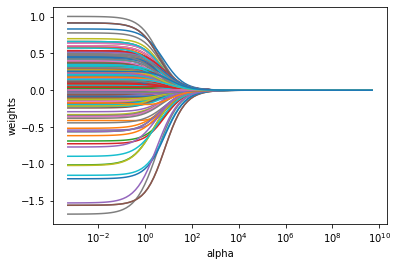

In [71]:
ax = plt.gca()
ax.plot(alfas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [72]:
ridge1 = Ridge(alpha = 6)
ridge1.fit(X_train, y_train)             
pred1 = ridge1.predict(X_test)           
print(pd.Series(ridge1.coef_, index = X.columns)) 
print(mean_squared_error(y_test, pred1))          

US viewers (million)    0.022661
Runtime (mins)         -0.043202
IMDB votes             -0.000012
Notable Death Count     0.079038
Director_Alan Taylor    0.006588
                          ...   
wound                   0.000000
yara                    0.111348
ygritt                  0.010625
yunkai                  0.018264
zo                      0.027724
Length: 551, dtype: float64
0.34930569133186007


In [53]:
ridge2 = Ridge(alpha = 10000)
ridge2.fit(X_train, y_train)             
pred2 = ridge2.predict(X_test)          
print(pd.Series(ridge2.coef_, index = X.columns))
print(mean_squared_error(y_test, pred2))          

US viewers (million)   -3.981841e-04
Runtime (mins)         -5.422121e-03
IMDB votes             -1.320602e-05
Notable Death Count     2.982800e-03
Director_Alan Taylor   -5.877651e-06
                            ...     
wound                   0.000000e+00
yara                    9.961307e-05
ygritt                 -1.243808e-07
yunkai                  1.938717e-05
zo                      1.908047e-05
Length: 551, dtype: float64
0.4096821404197826


In [55]:
#¿Qué alfa elegir?
ridgecv = RidgeCV(alphas = alfas)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

742.4841311272318

In [56]:
ridge3 = Ridge(alpha = ridgecv.alpha_)
ridge3.fit(X_train, y_train)             
pred3 = ridge3.predict(X_test)           
print(pd.Series(ridge3.coef_, index = X.columns)) 
print(mean_squared_error(y_test, pred3))

US viewers (million)    0.000863
Runtime (mins)         -0.025906
IMDB votes             -0.000011
Notable Death Count     0.029151
Director_Alan Taylor    0.000163
                          ...   
wound                   0.000000
yara                    0.001187
ygritt                  0.000036
yunkai                  0.000200
zo                      0.000238
Length: 551, dtype: float64
0.39366857351404483


Text(0, 0.5, 'weights')

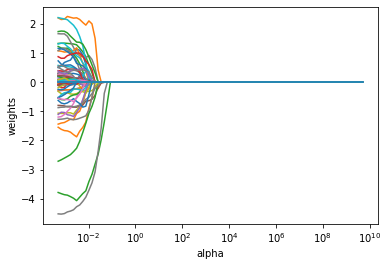

In [73]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alfas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alfas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [74]:
lassocv = LassoCV(alphas = alfas, cv = 10,  normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

0.32923021652062245

In [75]:
lassocv.alpha_

0.034463060521748405